In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.integrate import solve_ivp, odeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set the path to the project directory
os.chdir('/Users/olarinoyem/Project/data_driven_vaccination/')

In [8]:
# Set up matplotlib
plt.rcParams.update({
    # Font settings for clarity and compatibility with academic publications
    "font.family": "serif",  # Consistent font family
    # "font.serif": ["Times", "Computer Modern Roman"],  # Preferred serif fonts
    "font.size": 14,  # Base font size for better readability
    "text.usetex": False,  # Enable LaTeX for text rendering for a professional look

    # Figure aesthetics & size for detailed visuals and fit on publication pages
    "figure.figsize": (8, 5),  # Adjusted figure size for a balance between detail and fit
    "figure.facecolor": "white",  # White figure background for clean print
    "figure.autolayout": True,  # Enable automatic layout adjustments
    "figure.dpi": 400,  # High resolution figures
    "savefig.dpi": 400,  # High resolution saving settings
    "savefig.format": "pdf",  # Save figures in PDF format for publications
    "savefig.bbox": "tight",  # Tight bounding box around figures

    # Axes aesthetics for clarity and precision
    "axes.labelsize": 14,  # Clear labeling with larger font size
    "axes.titlesize": 20,  # Prominent titles for immediate recognition
    "axes.facecolor": "white",  # White axes background

    # Legend aesthetics for distinguishing plot elements
    "legend.fontsize": 12,  # Readable legend font size
    "legend.frameon": False,  # No frame around legend for cleaner look
    "legend.loc": "best",  # Optimal legend positioning

    # Line aesthetics for clear visual distinctions
    "lines.linewidth": 2,  # Thicker lines for visibility
    "lines.markersize": 8,  # Slightly smaller markers for balance

    # Tick label sizes for readability
    "xtick.labelsize": 12, 
    "ytick.labelsize": 12,
    "xtick.direction": "in",  # Ticks inside the plot
    "ytick.direction": "in",  # Ticks inside the plot
})

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# load the data and check the first few rows
df = pd.read_csv("data/processed/england_data.csv")
df.head()


,Unnamed: 0,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,areaName
0,0,2020-04-01,0.0,31201,15544.0,4382,3989.0,694.0,35571.0,4730.0,56171302,England
1,1,2020-04-02,1878.0,35138,15364.0,3937,3895.0,725.0,39466.0,5455.0,56171302,England
2,2,2020-04-03,2261.0,38526,18158.0,3388,3878.0,737.0,43344.0,6192.0,56171302,England
3,3,2020-04-04,2458.0,41972,20489.0,3446,3260.0,828.0,46604.0,7020.0,56171302,England
4,4,2020-04-05,2650.0,45418,22051.0,3446,2994.0,823.0,49598.0,7843.0,56171302,England


In [10]:
params = {
    "alpha": 0.1,   # Rate of transmission from the infected not requiring hospitalization
    "beta": 0.17,   # Rate of transmission from the infected requiring hospitalization
    "gamma": 1 / 16,# Recovery rate
    "theta": 0.001, # Mortality rate
    "N": 56171302,  # Total population for England
    # Parameters for hospitalized and critical
    "rho": 0.05,    # Hospitalization rate for infected
    "delta": 0.01,  # Mortality rate for non-hospitalized
    "eta": 0.02,    # Rate at which hospitalized become critical
    "kappa": 0.03,  # Recovery rate for hospitalized
    "mu": 0.01,     # Recovery rate for critical
    "xi": 0.005     # Mortality rate for critical
}

# Initial conditions [S0, I0, H0, C0, R0, D0] based on early data for England
initial_conditions = [56171302 - 20, 20, 0, 0, 0, 0]

In [11]:
def load_and_preprocess_data(filepath, recovery_period=16, rolling_window=7, start_date="2020-04-01"):
    """
    Load and preprocess the COVID-19 dataset for the SIHCRD model.

    Parameters:
    - filepath: Path to the CSV file containing the data.
    - recovery_period: Assumed number of days for recovery. Defaults to 16 days.
    - rolling_window: Window size for rolling average calculation. Defaults to 7 days.
    - start_date: The start date for filtering the data. Format 'YYYY-MM-DD'.

    Returns:
    - A preprocessed pandas DataFrame suitable for SIHCRD model integration.
    """
    df = pd.read_csv(filepath)

    # Ensure the dataset has the required columns
    required_columns = [
        "date", "cumulative_confirmed", "cumulative_deceased",
        "population", "covidOccupiedMVBeds", "hospitalCases"
    ]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Convert date to datetime and calculate days since start
    df["date"] = pd.to_datetime(df["date"])
    df["days_since_start"] = (df["date"] - pd.to_datetime(start_date)).dt.days

    # # Data Quality Checks for cumulative data
    # for col in ["cumulative_confirmed", "cumulative_deceased"]:
    #     if df[col].isnull().any() or (df[col].diff().dropna() < 0).any():
    #         raise ValueError(f"Inconsistent data in column: {col}")


    # Calculate recovered cases assuming a fixed recovery period
    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df["cumulative_deceased"].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)

    # Calculate active cases
    df["active_cases"] = df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]

    # Estimate the susceptible population
    df["S(t)"] = df["population"] - df["active_cases"] - df["recovered"] - df["cumulative_deceased"]
    
    # # Apply rolling average
    # for col in ["cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds"]:
    #     df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    # Filter data based on the start date
    df = df[df["date"] >= pd.to_datetime(start_date)].reset_index(drop=True)

    # Ensure no negative values
    df[["recovered", "active_cases", "S(t)"]] = df[["recovered", "active_cases", "S(t)"]].clip(lower=0)

    # Model Validation - Simple Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df["date"], df["cumulative_confirmed"], label='Cumulative Confirmed')
    plt.plot(df["date"], df["cumulative_deceased"], label='Cumulative Deceased')
    plt.plot(df["date"], df["recovered"], label='Recovered')
    plt.title('Check Epidemiological Trends Post-Preprocessing')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    return df

def split_time_series_data(df, train_size=0.7, val_size=0.15, test_size=0.15):
    """
    Splits the DataFrame into training, validation, and test sets while maintaining the time series order.

    Args:
        df (pd.DataFrame): The input DataFrame with time series data.
        train_size (float): Proportion of the dataset to allocate to training.
        val_size (float): Proportion of the dataset to allocate to validation.
        test_size (float): Proportion of the dataset to allocate to testing.

    Returns:
        tuple: Three DataFrames corresponding to the training, validation, and test sets.
    """
    if not np.isclose(train_size + val_size + test_size, 1.0):
        raise ValueError("train_size, val_size, and test_size should sum to 1.")

    n = len(df)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)

    train_data = df.iloc[:train_end]
    val_data = df.iloc[train_end:val_end]
    test_data = df.iloc[val_end:]

    return train_data, val_data, test_data

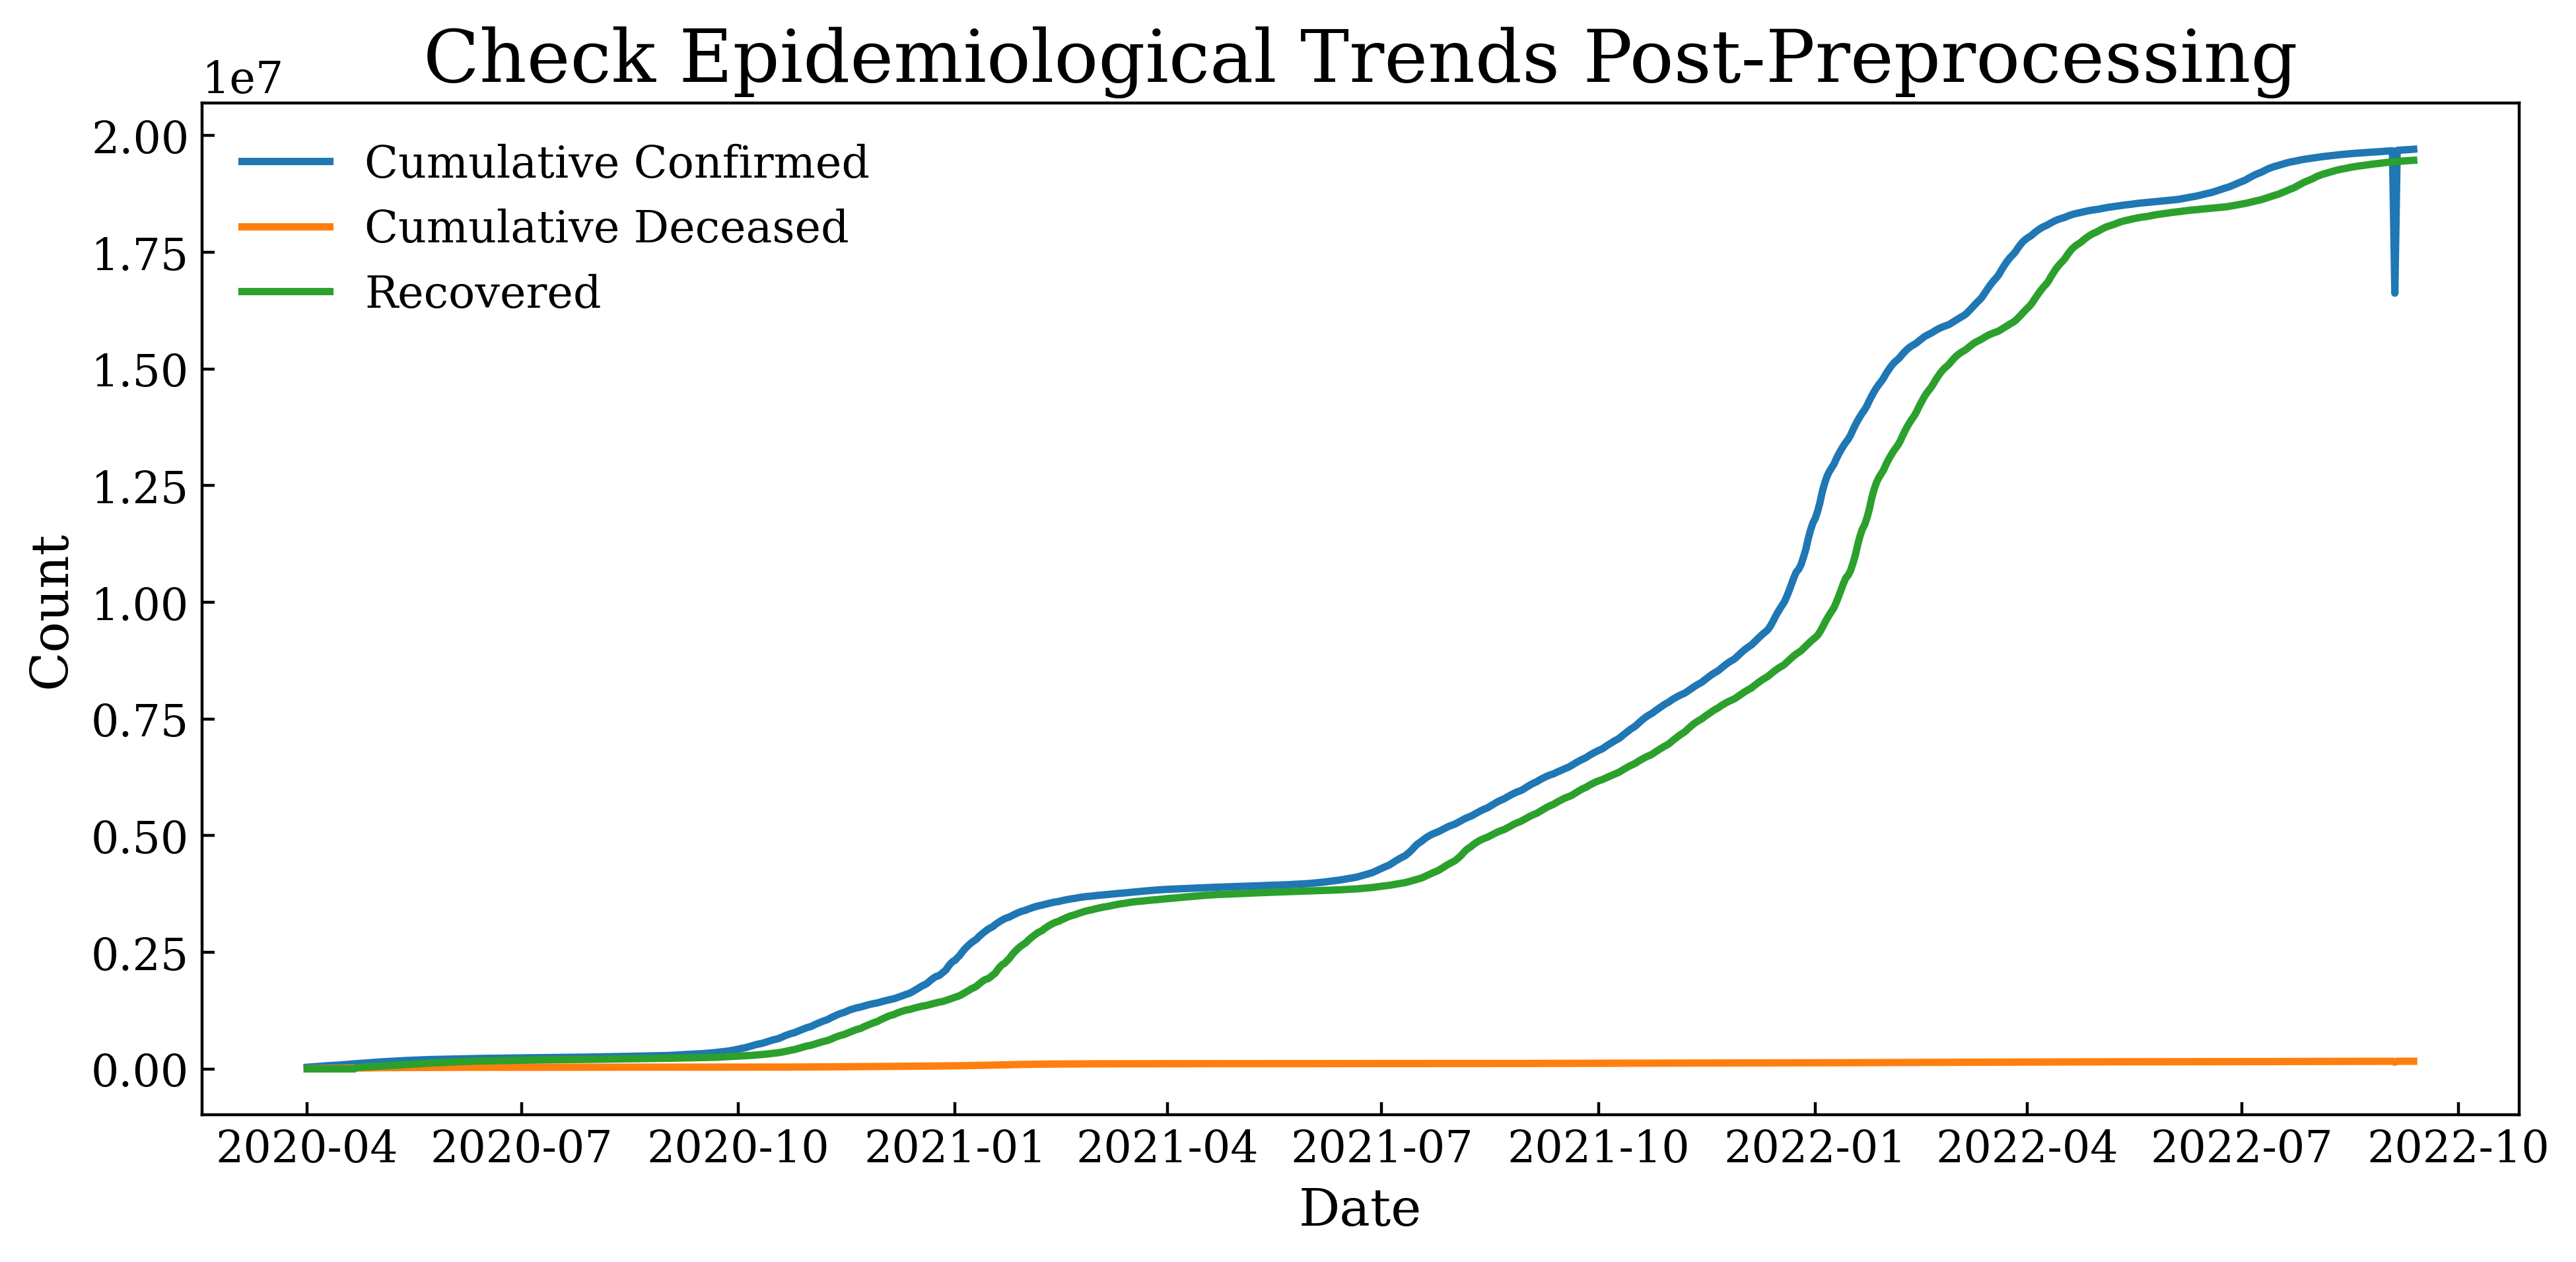

,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,areaName,days_since_start,recovered,active_cases,S(t)
0,2020-04-01,0.0,31201,15544.0,4382,3989.0,694.0,35571.0,4730.0,56171302,England,0,0.0,30841.0,56135731.0
1,2020-04-02,1878.0,35138,15364.0,3937,3895.0,725.0,39466.0,5455.0,56171302,England,1,0.0,34011.0,56131836.0
2,2020-04-03,2261.0,38526,18158.0,3388,3878.0,737.0,43344.0,6192.0,56171302,England,2,0.0,37152.0,56127958.0
3,2020-04-04,2458.0,41972,20489.0,3446,3260.0,828.0,46604.0,7020.0,56171302,England,3,0.0,39584.0,56124698.0
4,2020-04-05,2650.0,45418,22051.0,3446,2994.0,823.0,49598.0,7843.0,56171302,England,4,0.0,41755.0,56121704.0


In [12]:
data = load_and_preprocess_data("data/processed/england_data.csv", recovery_period=21, rolling_window=7, start_date="2020-04-01").drop("Unnamed: 0", axis=1)

data.head()

In [13]:
# select from the beginning of the pandemic in the data to the end of 2021
data = data[(data["date"] >= "2020-04-01") & (data["date"] <= "2021-12-31")]
data = data.reset_index(drop=True)
data.head()

,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,areaName,days_since_start,recovered,active_cases,S(t)
0,2020-04-01,0.0,31201,15544.0,4382,3989.0,694.0,35571.0,4730.0,56171302,England,0,0.0,30841.0,56135731.0
1,2020-04-02,1878.0,35138,15364.0,3937,3895.0,725.0,39466.0,5455.0,56171302,England,1,0.0,34011.0,56131836.0
2,2020-04-03,2261.0,38526,18158.0,3388,3878.0,737.0,43344.0,6192.0,56171302,England,2,0.0,37152.0,56127958.0
3,2020-04-04,2458.0,41972,20489.0,3446,3260.0,828.0,46604.0,7020.0,56171302,England,3,0.0,39584.0,56124698.0
4,2020-04-05,2650.0,45418,22051.0,3446,2994.0,823.0,49598.0,7843.0,56171302,England,4,0.0,41755.0,56121704.0


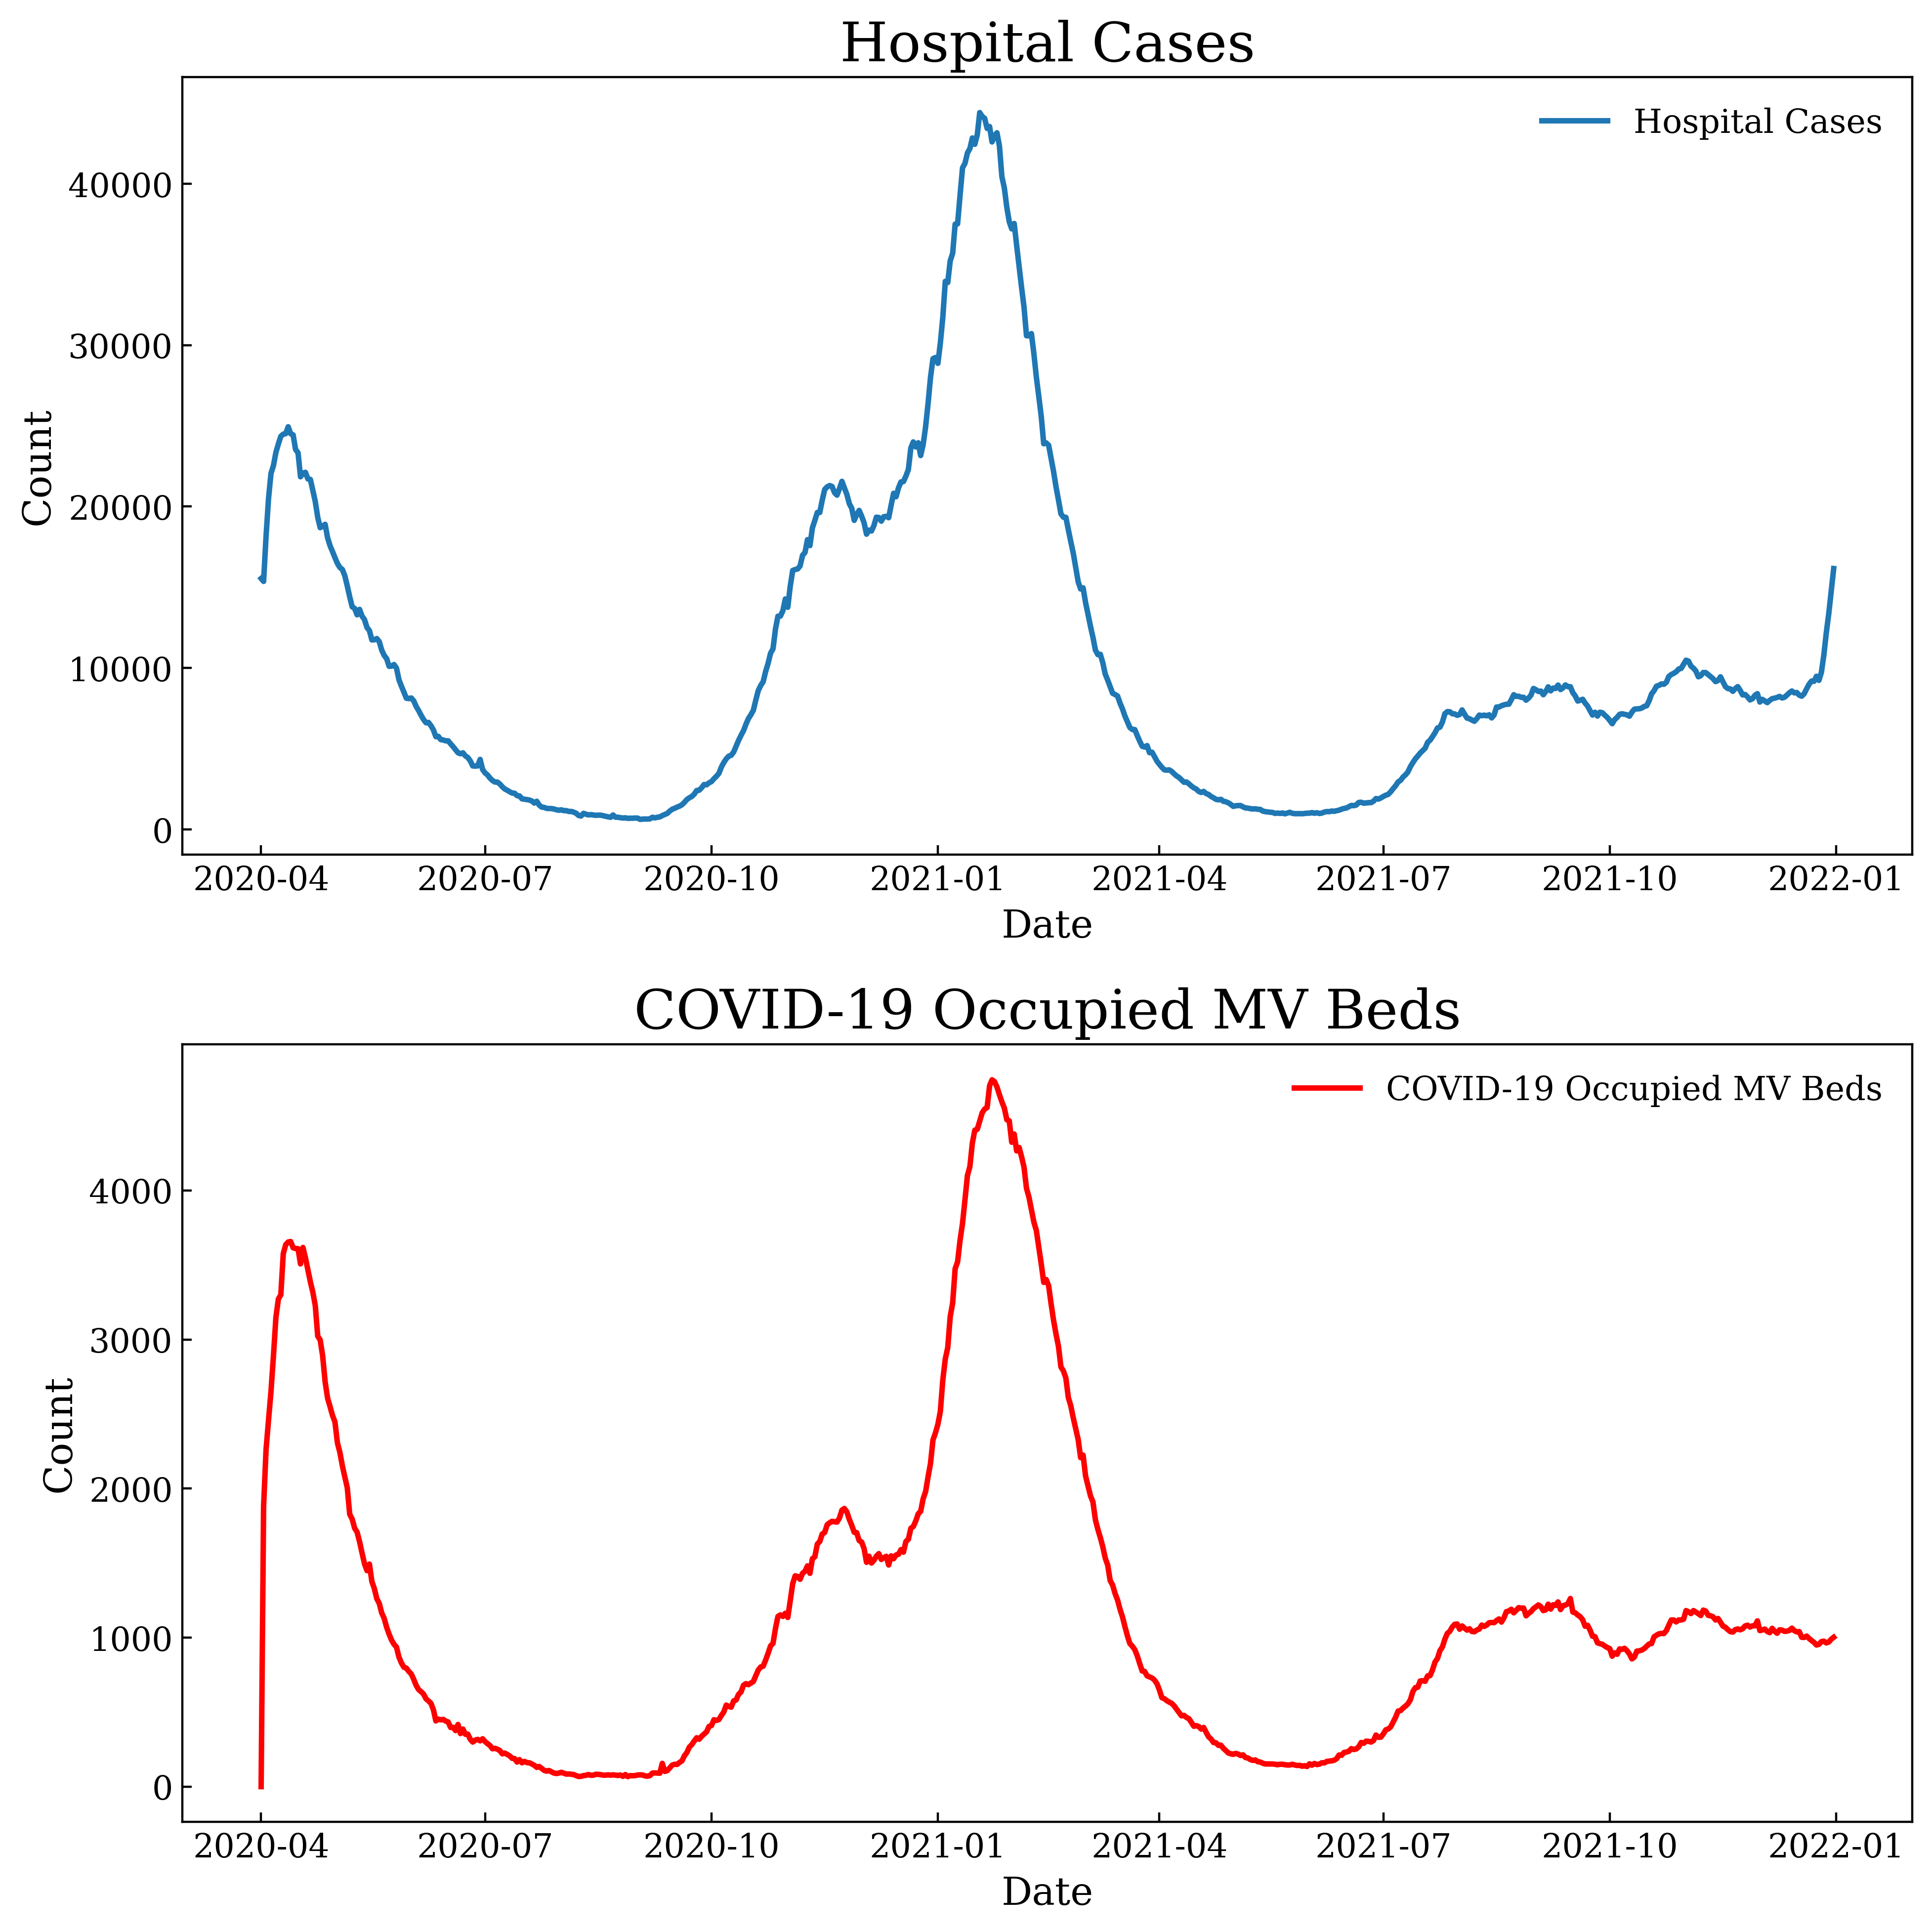

In [14]:
# visualize covidOccupiedMVBeds and hospitalCases on separate subplots
ax, fig = plt.subplots(2, 1, figsize=(10, 10))
fig[0].plot(data["date"], data["hospitalCases"], label="Hospital Cases")
fig[0].set_title("Hospital Cases")
fig[0].set_xlabel("Date")
fig[0].set_ylabel("Count")
fig[0].legend()

fig[1].plot(data["date"], data["covidOccupiedMVBeds"], label="COVID-19 Occupied MV Beds", color="red")
fig[1].set_title("COVID-19 Occupied MV Beds")
fig[1].set_xlabel("Date")
fig[1].set_ylabel("Count")
fig[1].legend()

plt.tight_layout()
plt.show()


In [15]:
# Split the data into training, validation, and test sets and scale the training data
train_data, val_data, test_data = split_time_series_data(data, train_size=0.7, val_size=0.15, test_size=0.15)

scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data[["cumulative_confirmed", "new_deceased", "covidOccupiedMVBeds", "hospitalCases", "recovered", "active_cases", "S(t)"]])
val_data_scaled = scaler.transform(val_data[["cumulative_confirmed", "new_deceased", "covidOccupiedMVBeds", "hospitalCases", "recovered", "active_cases", "S(t)"]])
test_data_scaled = scaler.transform(test_data[["cumulative_confirmed", "new_deceased", "covidOccupiedMVBeds", "hospitalCases", "recovered", "active_cases", "S(t)"]])

In [ ]:
# transform the data into pytprch tensors for physics-informed neural network
train_data_scaled = torch.FloatTensor(train_data_scaled).to(device)
val_data_scaled = torch.FloatTensor(val_data_scaled).to(device)
test_data_scaled = torch.FloatTensor(test_data_scaled).to(device)

